In [1]:
import tqdm
import pathlib as pl
import numpy as np
import matplotlib.pyplot as plt

from src.data import FrameDataset, RayDataset, get_rays

import torch
from torch import nn
import torchvision

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [2]:
def get_path_number(path: pl.Path):
    return int(path.stem.split("-")[-1])


def get_sample(dataset, idx=0):
    H, W = dataset.shape
    focal = dataset.focal
    img, _, c2w = dataset[idx]
    r_o, r_d = get_rays(H, W, focal, c2w)
    img = img[:3].swapaxes(0, 2).swapaxes(0, 1)
    return r_o, r_d, img


def save_tensor_as_img(x: torch.Tensor, path: pl.Path):
    x = x.detach().cpu().permute(2, 0, 1)
    im = torchvision.transforms.ToPILImage("RGB")(x)
    im.save(path)


@torch.jit.script
def strat_sampling(
    N: int, t_near: float, t_far: float, device: torch.device
) -> torch.Tensor:
    draws = torch.arange(N, device=device) + torch.rand(N, device=device)
    samples = t_near + draws * (t_far - t_near) / N
    return samples


@torch.jit.script
def positional_encoding(p: torch.Tensor, L: int, device: torch.device) -> torch.Tensor:
    assert len(p.shape) == 3
    assert L % 2 == 0

    B, NB, D = p.shape

    pe = torch.zeros(B, NB, 2 * D * L + D, device=device)
    pe[..., :3] = p
    for i in range(0, L):
        pe[..., 3 + 6*i   : 3 + 6*i+3] = torch.sin(2**i * p)
        pe[..., 3 + 6*i+3 : 3 + 6*i+6] = torch.cos(2**i * p)
    return pe


@torch.jit.script
def positional_encoding_vec(
    p: torch.Tensor, L: int, device: torch.device
) -> torch.Tensor:
    # TODO: Fix code
    assert len(p.shape) == 3
    B, NB, D = p.shape

    # Z denotes transformed input p
    # Z_ij becomes 2^i * p_i * p_j for each i in 0..L-1 and each component j in 1..3
    # Thus dimension is <B, NB, D, L>
    z = (2 ** torch.arange(L, device=device).repeat(D, 1)) * (torch.pi * p[..., None])

    # X denotes the encoded value for each transformed input
    x1 = torch.sin(z)
    x2 = torch.cos(z)

    # We want ordering sin(x) cos(x) sin(y) cos(y) sin(z) cos(z) repeated for each element in 1..L
    # First we stack encoding into a matrix, then we flatten the matrix to put each row side by side.
    x = torch.stack((x1, x2), dim=4)  # <B, NB, D, L, 2>
    x = x.swapaxes(2, 3)  # <B, NB, L, D, 2>
    x = x.reshape(B, NB, 2 * D * L)  # Finally, flatten to shape <B, NB, 2*D*L>

    return x


@torch.jit.script
def get_t(
    n_rays: int, n_bins: int, t_near: float, t_far: float, device: torch.device
) -> torch.Tensor:
    t = strat_sampling(n_rays * n_bins, t_near, t_far, device)
    t = t.reshape(n_rays, n_bins)  # B, NB
    return t


@torch.jit.script
def batchify_rays(batch: tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
    # r_o: <S, S, D>
    # r_d: <S, S, D>
    # C_r: <4, S, S>
    # img_size: S
    # n_rays: N = S*S
    # N = S * S
    # chunk_size: C = (S/NC)^2

    r_o, r_d, C_r = batch
    S, _, D = r_o.shape
    r_o = r_o.reshape(S * S, D)
    r_d = r_d.reshape(S * S, D)

    # We only care about RGB, which is the first three dimensions
    # We also reshape it to <N, 3> to make it an RGB value for each ray
    C_r = C_r[:3].reshape(3, -1).T  # <N, D>

    # r_o, r_d: <N, D>
    # C_r: <N, 3>
    return r_o, r_d, C_r


@torch.jit.script
def preprocess_rays(
    r_o: torch.Tensor,
    r_d: torch.Tensor,
    n_bins: int,
    t_near: float,
    t_far: float,
    L1: int,
    L2: int,
    device: torch.device,
):
    # r_o: <N, D>
    # r_o: <N, D>

    N, D = r_o.shape

    t = get_t(N, n_bins, t_near, t_far, device=device)  # <C, NB>
    r_d = nn.functional.normalize(r_d, dim=-1)  # <N, D>

    # Reshape the dimensions for broadcasting during x = r_o + t * r_d
    r_o = r_o.reshape(N, 1, D)

    # Repeat this for broadcasting when multiplying
    r_d = r_d.reshape(N, 1, D).repeat(1, n_bins, 1)

    # We will do elementwise multiplication with each dimension, so we add a dimension at the end for broadcasting
    tmul = t[..., None]
    x = r_o + tmul * r_d  # <N, NB, D>

    # <N, NB, 2*D*L>
    ex = positional_encoding(x, L1, device=device)
    ed = positional_encoding(r_d, L2, device=device)

    ex = ex.reshape(N, n_bins, 6 * L1 + 3)  # <C, NB, 2*D*L+D>
    ed = ed.reshape(N, n_bins, 6 * L2 + 3)  # <C, NB, 2*D*L+D>

    return ex, ed, t


@torch.jit.script
def expected_color(
    c: torch.Tensor, sigma: torch.Tensor, t: torch.Tensor
) -> torch.Tensor:
    # N: number of rays in batch
    # NB: number of bins
    # c: <N, NB, 3>
    # sigma: <N, NB>
    # t: <N, NB>

    assert len(c.shape) == 3
    assert len(sigma.shape) == 2
    assert len(t.shape) == 2
    assert c.max() <= 1

    # Multiply up to T-1. For effeciency purposes, we keep the last dimension, but it gets overwritten later.
    dt = torch.roll(t, -1, dims=-1) - t
    sig_dt = dt * sigma

    # Compute cumuluative probability,
    # Since equation (3) sums T_i from i=1 to i-1, we set the first value to (exp 0 = 1) and ignore the last value.
    # We don't remove it from the tensor yet, but it will be overwritten later.
    T = torch.exp(-torch.cumsum(sig_dt, dim=-1))
    T = T.roll(1, dims=-1)
    T[..., 0] = 1

    # If the point has not collided with anything up to the end, it should definitely collide at the end
    alpha = 1 - torch.exp(-sig_dt)
    alpha[..., -1] = 1

    w = T * alpha

    c_hat = torch.einsum("nb,nbc->nc", w, c)
    return c_hat


def render_rays(
    model: nn.Module,
    r_o_full: torch.Tensor,
    r_d_full: torch.Tensor,
    device: torch.device,
    chunk_size: int,
    n_bins: int,
    t_near: float,
    t_far: float,
    L1: int,
    L2: int,
) -> torch.Tensor:
    model.eval()
    with torch.no_grad():
        H, W, _ = r_o_full.shape
        n_rays = H * W

        assert n_rays % chunk_size == 0

        r_o_full = r_o_full.reshape(n_rays, 3).to(device)
        r_d_full = r_d_full.reshape(n_rays, 3).to(device)
        c_hat_full = torch.zeros((n_rays, 3), device=device, dtype=torch.float32)

        for i in tqdm.tqdm(range(0, n_rays, chunk_size)):
            r_o = r_o_full[i : i + chunk_size].to(device)
            r_d = r_d_full[i : i + chunk_size].to(device)

            ex, ed, t = preprocess_rays(
                r_o, r_d, n_bins, t_near, t_far, L1, L2, device=device
            )

            c, sigma = model(ex, ed)
            c_hat = expected_color(c, sigma, t)
            c_hat_full[i : i + chunk_size] = c_hat

        c_hat_full = c_hat_full.reshape((H, W, 3))
        return c_hat_full


def train_nerf_batch(
    batch: tuple[torch.Tensor, torch.Tensor, torch.Tensor],
    model: nn.Module,
    criterion: nn.Module,
    optim: torch.optim.Optimizer,
    chunk_size: int,
    n_bins: int,
    t_near: float,
    t_far: float,
    L1: int,
    L2: int,
    device: torch.device,
) -> dict[str, any]:
    img_size = batch[0].size(0)
    n_rays = img_size * img_size
    assert n_rays % chunk_size == 0

    r_o_full, r_d_full, C_r_full = batchify_rays(batch)

    model.train()
    running_loss = 0

    for i in range(0, n_rays, chunk_size):
        optim.zero_grad()

        r_o = r_o_full[i : i + chunk_size].to(device)
        r_d = r_d_full[i : i + chunk_size].to(device)
        C_r = C_r_full[i : i + chunk_size].to(device)

        ex, ed, t = preprocess_rays(
            r_o, r_d, n_bins, t_near, t_far, L1, L2, device=device
        )

        c, sigma = model(ex, ed)
        c_hat = expected_color(c, sigma, t)

        batch_loss = criterion(c_hat, C_r)
        batch_loss.backward()

        optim.step()

        running_loss += batch_loss.item()

    train_loss = running_loss / (n_rays / chunk_size)
    return train_loss


def eval_nerf_batch(
    batch: tuple[torch.Tensor, torch.Tensor, torch.Tensor],
    model: nn.Module,
    criterion: nn.Module,
    chunk_size: int,
    n_bins: int,
    t_near: float,
    t_far: float,
    L1: int,
    L2: int,
    device: torch.device,
):
    img_size = batch[0].size(0)
    n_rays = img_size * img_size
    assert n_rays % chunk_size == 0

    model.eval()
    with torch.no_grad():
        img_size = batch[0].size(0)
        n_rays = img_size * img_size
        assert n_rays % chunk_size == 0

        r_o_full, r_d_full, C_r_full = batchify_rays(batch)
        running_loss = 0

        for i in range(0, n_rays, chunk_size):
            r_o = r_o_full[i : i + chunk_size].to(device)
            r_d = r_d_full[i : i + chunk_size].to(device)
            C_r = C_r_full[i : i + chunk_size].to(device)

            ex, ed, t = preprocess_rays(
                r_o, r_d, n_bins, t_near, t_far, L1, L2, device=device
            )

            c, sigma = model(ex, ed)
            c_hat = expected_color(c, sigma, t)

            batch_loss = criterion(c_hat, C_r)
            running_loss += batch_loss.item()

    val_loss = running_loss / (n_rays / chunk_size)
    return val_loss


def train_nerf(
    model: nn.Module,
    optim: torch.optim.Optimizer,
    criterion: nn.Module,
    train_dataset,
    val_dataset,
    n_epochs: int,
    chunk_size: int,
    n_bins: int,
    t_near: float,
    t_far: float,
    L1: int,
    L2: int,
    base_save_path: pl.Path,
    device: torch.device,
    load_checkpoint_path: pl.Path = None,
    shuffle_train: bool = True,
    shuffle_val: bool = True,
    limit_train_size: int = None,
    limit_val_size: int = None,
    render_freq: int = None,
    ex_sample: tuple[torch.Tensor, torch.Tensor, torch.Tensor] = None,
):
    if not base_save_path.exists():
        raise ValueError

    if load_checkpoint_path:
        if not load_checkpoint_path.exists():
            raise ValueError

        checkpoint = torch.load(str(load_checkpoint_path))
        model.load_state_dict(checkpoint["model_state_dict"])
        optim.load_state_dict(checkpoint["optim_state_dict"])
        epoch = checkpoint["epoch"] + 1

    else:
        checkpoint = {
            "epoch": None,
            "train_loss": [],
            "val_loss": [],
            "model_state_dict": None,
            "optim_state_dict": None,
        }
        epoch = 0

    model_save_path = base_save_path / model.name
    model_save_path.mkdir(exist_ok=True)

    n_saved_versions = len(list(model_save_path.glob("version-*")))
    if n_saved_versions > 0:
        n_saved_versions = (
            get_path_number(
                sorted(
                    model_save_path.glob("version-*"),
                    key=get_path_number,
                )[-1]
            )
            + 1
        )

    version_path = model_save_path / f"version-{n_saved_versions}"
    version_path.mkdir(parents=True, exist_ok=False)

    if (render_freq is not None) and ex_sample and epoch == 0:
        ex_ro, ex_rd, ex_ref = ex_sample
        ref_img_path = version_path / "render_ref.png"
        save_tensor_as_img(ex_ref, ref_img_path)

    while epoch < n_epochs:
        print(f"epoch: {epoch}/{n_epochs}")
        train_loss_epoch = 0
        n_batches_train = (
            len(train_dataset) if (limit_train_size is None) else limit_train_size
        )
        batch_idxs_train = (
            torch.randperm(n_batches_train)
            if shuffle_train
            else torch.arange(n_batches_train)
        )
        for i_batch_train in tqdm.tqdm(batch_idxs_train):
            batch = train_dataset[i_batch_train]
            train_loss_batch = train_nerf_batch(
                batch,
                model,
                criterion,
                optim,
                chunk_size,
                n_bins,
                t_near,
                t_far,
                L1,
                L2,
                device=device,
            )
            train_loss_epoch += train_loss_batch

        val_loss_epoch = 0
        n_batches_val = len(val_dataset) if (limit_val_size is None) else limit_val_size
        batch_idxs_val = (
            torch.randperm(n_batches_val)
            if shuffle_val
            else torch.arange(n_batches_val)
        )
        for i_batch_val in tqdm.tqdm(batch_idxs_val):
            batch = val_dataset[i_batch_val]
            val_loss_batch = eval_nerf_batch(
                batch,
                model,
                criterion,
                chunk_size,
                n_bins,
                t_near,
                t_far,
                L1,
                L2,
                device=device,
            )
            val_loss_epoch += val_loss_batch

        train_loss = train_loss_epoch / n_batches_train
        val_loss = val_loss_epoch / n_batches_val

        checkpoint_path = version_path / f"checkpoint-{epoch}"
        print(f"\ttrain loss: {train_loss:.5e}\n\tval loss: {val_loss:.5e}\n")

        checkpoint["epoch"] = epoch
        checkpoint["train_loss"].append(train_loss)
        checkpoint["val_loss"].append(val_loss)
        checkpoint["model_state_dict"] = model.state_dict()
        checkpoint["optim_state_dict"] = optim.state_dict()
        torch.save(checkpoint, checkpoint_path)

        if (render_freq is not None) and ex_sample and (epoch % render_freq == 0):
            ex_ro, ex_rd, ex_ref = ex_sample
            ex_render = render_rays(
                model,
                ex_ro,
                ex_rd,
                device=device,
                chunk_size=chunk_size,
                n_bins=n_bins,
                t_near=t_near,
                t_far=t_far,
                L1=L1,
                L2=L2,
            )
            render_path = version_path / f"render_{epoch}.png"
            save_tensor_as_img(ex_render, render_path)

        epoch += 1

    return checkpoint

torch.Size([100, 100, 3])
torch.Size([3, 100, 100])
Image shape: torch.Size([100, 100, 3])


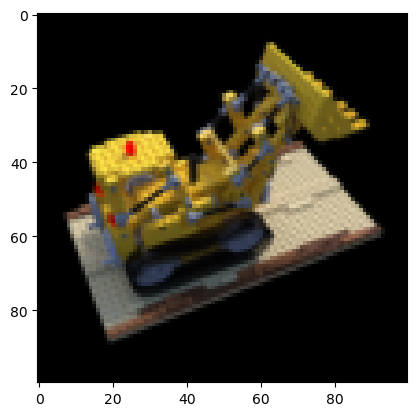

In [3]:

TRAIN_MODEL = True

chunk_size = 2500
n_epochs = 50
n_bins = 64
t_near = 2.0
t_far = 6.0
n_hidden = 256
learning_rate = 5e-4
downscale_factor = 8
L1 = 10
L2 = 4


base_save_path = pl.Path('./models/')

# Set these when you want to test. 
# If None, the full dataset will be used on each epoch.
limit_train_size = None
limit_val_size = 30


data_source_name = "NeRF_Data"
dataset_name = "nerf_synthetic"
scene_name = "lego"

root_data_dir = pl.Path('./data/')
data_path = root_data_dir / data_source_name / dataset_name / scene_name

train_frame_dataset = FrameDataset(data_path, "train", downsample_factor=downscale_factor)
val_frame_dataset = FrameDataset(data_path, "val", downsample_factor=downscale_factor)
test_frame_dataset = FrameDataset(data_path, "test", downsample_factor=downscale_factor)

train_ray_dataset = RayDataset(train_frame_dataset)
val_ray_dataset = RayDataset(val_frame_dataset)
test_ray_dataset = RayDataset(test_frame_dataset)

ref_idx = 18
ref_ro, ref_rd, ref_img = get_sample(test_frame_dataset, ref_idx)


print(ref_img.shape)
print(ref_img.permute(2, 0, 1).shape)
im = torchvision.transforms.ToPILImage("RGB")(ref_img.permute(2, 0, 1))
im.save("tmp.png")



print(f"Image shape: {ref_img.shape}")
plt.imshow(ref_img)


In [5]:
from src.model import LargeNetNoView, MediumNet, TestNet

#model = TestNet("testnet", L1, L2, 3, n_hidden).to(DEVICE)
#model = MediumNet("mediumnet", L1, L2, 3, n_hidden).to(DEVICE)
model = LargeNetNoView("largenet-nw", L1, L2, 3, n_hidden).to(DEVICE)
model = torch.jit.script(model)
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
#load_checkpoint_path = pl.Path('./models/largenet-nw/version-1/checkpoint-20')
load_checkpoint_path = None


if TRAIN_MODEL:
    train_nerf(
        model=model,
        optim=optim,
        criterion=criterion,
        train_dataset=train_ray_dataset,
        val_dataset=val_ray_dataset,
        n_epochs=n_epochs,
        chunk_size=chunk_size,
        n_bins=n_bins,
        t_near=t_near,
        t_far=t_far,
        L1=L1,
        L2=L2,
        base_save_path=base_save_path,
        device=DEVICE,
        load_checkpoint_path=load_checkpoint_path,
        limit_train_size=limit_train_size,
        limit_val_size=limit_val_size,
        render_freq=1,
        ex_sample=(ref_ro, ref_rd, ref_img),
    )

epoch: 0/50


100%|██████████| 30/30 [00:08<00:00,  3.41it/s]


	train loss: 6.55397e-02
	val loss: 5.83910e-02



100%|██████████| 4/4 [00:00<00:00, 15.06it/s]


epoch: 1/50


100%|██████████| 30/30 [00:08<00:00,  3.48it/s]


	train loss: 6.03079e-02
	val loss: 5.83095e-02



100%|██████████| 4/4 [00:00<00:00, 14.68it/s]


epoch: 2/50


100%|██████████| 30/30 [00:08<00:00,  3.48it/s]


	train loss: 6.00092e-02
	val loss: 5.81922e-02



100%|██████████| 4/4 [00:00<00:00, 14.71it/s]


epoch: 3/50


100%|██████████| 30/30 [00:08<00:00,  3.44it/s]


	train loss: 5.96803e-02
	val loss: 5.80415e-02



100%|██████████| 4/4 [00:00<00:00, 14.68it/s]


epoch: 4/50


100%|██████████| 30/30 [00:08<00:00,  3.52it/s]


	train loss: 5.94488e-02
	val loss: 5.81995e-02



100%|██████████| 4/4 [00:00<00:00, 15.01it/s]


epoch: 5/50


100%|██████████| 30/30 [00:08<00:00,  3.51it/s]


	train loss: 5.91283e-02
	val loss: 5.83822e-02



100%|██████████| 4/4 [00:00<00:00, 14.93it/s]


epoch: 6/50


100%|██████████| 30/30 [00:08<00:00,  3.50it/s]


	train loss: 5.88926e-02
	val loss: 5.85535e-02



100%|██████████| 4/4 [00:00<00:00, 14.57it/s]


epoch: 7/50


100%|██████████| 30/30 [00:08<00:00,  3.45it/s]


	train loss: 5.85838e-02
	val loss: 5.80735e-02



100%|██████████| 4/4 [00:00<00:00, 14.49it/s]


epoch: 8/50


100%|██████████| 30/30 [00:08<00:00,  3.54it/s]


	train loss: 5.81990e-02
	val loss: 5.81296e-02



100%|██████████| 4/4 [00:00<00:00, 15.07it/s]


epoch: 9/50


100%|██████████| 30/30 [00:08<00:00,  3.53it/s]


	train loss: 5.76751e-02
	val loss: 5.95328e-02



100%|██████████| 4/4 [00:00<00:00, 14.84it/s]


epoch: 10/50


100%|██████████| 30/30 [00:08<00:00,  3.53it/s]


	train loss: 5.72822e-02
	val loss: 5.95968e-02



100%|██████████| 4/4 [00:00<00:00, 14.98it/s]


epoch: 11/50


100%|██████████| 30/30 [00:08<00:00,  3.53it/s]


	train loss: 5.64716e-02
	val loss: 5.95955e-02



100%|██████████| 4/4 [00:00<00:00, 14.95it/s]


epoch: 12/50


100%|██████████| 30/30 [00:08<00:00,  3.54it/s]


	train loss: 5.56081e-02
	val loss: 6.08438e-02



100%|██████████| 4/4 [00:00<00:00, 14.87it/s]


epoch: 13/50


100%|██████████| 30/30 [00:08<00:00,  3.54it/s]


	train loss: 5.47570e-02
	val loss: 5.99984e-02



100%|██████████| 4/4 [00:00<00:00, 14.95it/s]


epoch: 14/50


100%|██████████| 30/30 [00:08<00:00,  3.54it/s]


	train loss: 5.37144e-02
	val loss: 6.01826e-02



100%|██████████| 4/4 [00:00<00:00, 14.90it/s]


epoch: 15/50


100%|██████████| 30/30 [00:08<00:00,  3.54it/s]


	train loss: 5.28380e-02
	val loss: 6.12928e-02



100%|██████████| 4/4 [00:00<00:00, 15.07it/s]


epoch: 16/50


 89%|████████▉ | 89/100 [01:07<00:08,  1.32it/s]


KeyboardInterrupt: 

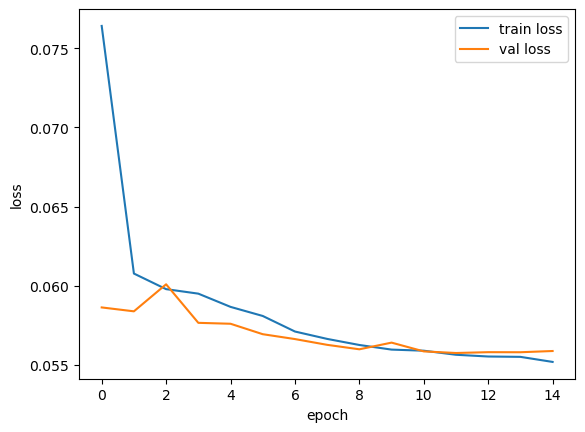

In [ ]:
cp = torch.load(pl.Path('models/mediumnet/version-7/checkpoint-14'))
train_loss = cp["train_loss"]
val_loss = cp["val_loss"]
n_epochs = cp["epoch"] + 1

plt.plot(np.arange(n_epochs), train_loss, label="train loss")
plt.plot(np.arange(n_epochs), val_loss, label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

In [ ]:
import numpy as np

def expected_color_2(
    c: torch.Tensor, sigma: torch.Tensor, t: torch.Tensor
) -> torch.Tensor:
    # N: number of rays in batch
    # NB: number of bins
    # c: <N, NB, 3>
    # sigma: <N, NB>
    # t: <N, NB>

    assert len(c.shape) == 3
    assert len(sigma.shape) == 2
    assert len(t.shape) == 2
    assert c.max() <= 1

    # Multiply up to T-1. For effeciency purposes, we keep the last dimension, but it gets overwritten later.
    dt = torch.roll(t, -1, dims=-1) - t
    sig_dt = dt * sigma

    # Compute cumuluative probability,
    # Since equation (3) sums T_i from i=1 to i-1, we set the first value to (exp 0 = 1) and ignore the last value.
    # We don't remove it from the tensor yet, but it will be overwritten later.
    T = torch.exp(-torch.cumsum(sig_dt, dim=-1))
    T = T.roll(1, dims=-1)
    T[..., 0] = 1

    # If the point has not collided with anything up to the end, it should definitely collide at the end
    alpha = (1 - torch.exp(-sig_dt)) 
    alpha[..., -1] = 1

    w = T * alpha

    c_hat = torch.einsum("nb,nbc->nc", w, c)
    return c_hat

t = torch.Tensor([[0.1, 0.9, 1.1]])
c = torch.Tensor([[[1, 0, 0], [0, 1, 0], [0, 0, 1]]])
sigma = torch.Tensor([[0.2, 0.6, 1]])


# delta_1 = 0.8 - 0.3 = 0.5
# delta_2 = 1.1 - 0.8 = 0.3
# sidel_1 = 0.2*0.5 = 0.10
# sidel_2 = 0.6*0.3 = 0.18
# T_1 = 1
# T_2 = e^-(0.10) = 0.9048
# T_3 = e^-(0.10+0.18) = 0.7558
# hili_1 = (1-e^(-sidel_1)) = 1-e^(-0.10) = 0.0952
# hili_2 = (1-e^(-sidel_2)) = 1-e^(-0.18) = 0.1647
# hili_3 = 1

exp_c = 0
for i in range(3):
    if i == 2:
        T_i = 0
        for j in range(i):
            delta = t[0, j+1]-t[0, j]
            T_i += sigma[0, j]*delta
        T_i = np.exp(-T_i)
        exp_c += T_i * c[0, i]
        continue

    if i == 0:
        T_i = 1

    else:
        T_i = 0
        for j in range(i):
            delta = t[0, j+1]-t[0, j] 
            T_i += sigma[0, j] *delta 
        T_i = np.exp(-T_i)

    delta = t[0, i+1]-t[0, i]
    exp_c += T_i * (1 - np.exp(-sigma[0, i]*delta)) * c[0, i]
        

exp_c, expected_color(c, sigma, t), expected_color_2(c, sigma, t)


tensor([[1.0000, 0.8521, 0.7558]])
tensor([[ 0.1479,  0.1131, -1.7183]])


(tensor([0.1479, 0.0964, 0.7558]),
 tensor([[0.1479, 0.0964, 0.2800]]),
 tensor([[0.1479, 0.0964, 0.7558]]))

In [ ]:
def positional_encoding_2(p: torch.Tensor, L: int) -> torch.Tensor:
    assert len(p.shape) == 3
    B, NB, D = p.shape

    print(D)
    print(p.shape)
    z = (2**torch.arange(L-1).repeat(D, 1)) * p[..., None]
    print(z, z.shape)
    x1 = torch.sin(z)
    x2 = torch.cos(z)

    x = torch.stack((x1, x2), dim=-1)
    print(x.shape)
    #z4 = torch.stack((p, z3), dim=-1)

    #z4 = z3.flatten(2)

    print(x)

    # Z denotes transformed input p
    # Z_ij becomes 2^i * p_i * p_j for each i in 0..L-1 and each component j in 1..3
    # Thus dimension is <B, NB, D, L>
#    z = (2 ** torch.arange(L).repeat(1, 1, D, 1)) * (torch.pi * p[..., None])
    #z = (2 ** torch.arange(L).repeat(1, 1, D, 1)) * p[..., None] 
    #print("z", z)

    # X denotes the encoded value for each transformed input
    #x1 = torch.sin(z)
    #x2 = torch.cos(z)

    # We want ordering sin(x) cos(x) sin(y) cos(y) sin(z) cos(z) repeated for each element in 1..L
    # First we stack encoding into a matrix, then we flatten the matrix to put each row side by side.
    #x = torch.stack((x1, x2), dim=-1)  # <B, NB, D, L, 2>
    #x = x.swapaxes(3, 4)
    #x = x.swapaxes(2, 3).swapaxes(3, 4)  # <B, NB, L, D, 2>
    #x = x.reshape(B, NB, 2 * D * L)  # Finally, flatten to shape <B, NB, 2*D*L>

    return x


a = torch.Tensor([[[-2, 1, 4], [-3, -2, 1]]]).long()
a


def positional_encoding(p: torch.Tensor, L: int, device: torch.device) -> torch.Tensor:
    assert len(p.shape) == 3
    assert L % 2 == 0

    B, NB, D = p.shape

    pe = torch.zeros(B, NB, 2 * D * L + D)
    pe[..., :3] = p
    for i in range(0, L):
        pe[..., 3 + 6*i   : 3 + 6*i+3] = torch.sin(2**i * p)
        pe[..., 3 + 6*i+3 : 3 + 6*i+6] = torch.cos(2**i * p)
    return pe


def posenc(x, L):
  rets = [x]
  for i in range(L):
    for fn in [torch.sin, torch.cos]:
      rets.append(fn(2.**i * x))
  return torch.cat(rets, -1)

print("correct", posenc(a, 6))
print("old", positional_encoding(a, 6 , torch.device("cpu")))

correct tensor([[[-2.0000,  1.0000,  4.0000, -0.9093,  0.8415, -0.7568, -0.4161,
           0.5403, -0.6536,  0.7568,  0.9093,  0.9894, -0.6536, -0.4161,
          -0.1455, -0.9894, -0.7568, -0.2879, -0.1455, -0.6536, -0.9577,
           0.2879,  0.9894,  0.5514, -0.9577, -0.1455,  0.8342, -0.5514,
          -0.2879,  0.9200,  0.8342, -0.9577,  0.3919, -0.9200,  0.5514,
           0.7210,  0.3919,  0.8342, -0.6929],
         [-3.0000, -2.0000,  1.0000, -0.1411, -0.9093,  0.8415, -0.9900,
          -0.4161,  0.5403,  0.2794,  0.7568,  0.9093,  0.9602, -0.6536,
          -0.4161,  0.5366, -0.9894, -0.7568,  0.8439, -0.1455, -0.6536,
           0.9056,  0.2879,  0.9894,  0.4242, -0.9577, -0.1455,  0.7683,
          -0.5514, -0.2879, -0.6401,  0.8342, -0.9577, -0.9836, -0.9200,
           0.5514, -0.1804,  0.3919,  0.8342]]])
old tensor([[[-2.0000,  1.0000,  4.0000, -0.9093,  0.8415, -0.7568, -0.4161,
           0.5403, -0.6536,  0.7568,  0.9093,  0.9894, -0.6536, -0.4161,
          -0.145